# Space Ducks, Cigars & FFTs

                                                                              Oleg Smirnov <o.smirnov@ru.ac.za>

This notebook provides some supplementary material for the Week 4 lectures on Fourier transforms. The notebook shows how to use the ``numpy.fft`` library, and puts it to work to demonstrate some properties of the Fourier transform.

Software pre-requisites: ``jupyter python3-scipy python3-matplotlib``

## Duck, meet world
For starters, let's use scipy to read in a greyscale JPG image of a duck, and normalize it intensity to [0,1]. 

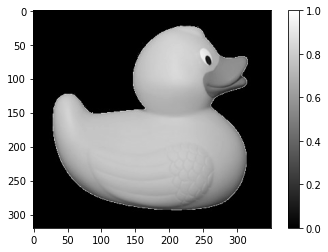

In [24]:
%matplotlib inline
from pylab import *
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

scipy.__version__
duck0 = plt.imread("duck-black.jpg")
duck0 = 0.2989 * duck0[:, :, 0] + 0.5870 * duck0[:, :, 1] + 0.1140 * duck0[:, :, 2] # converting RGB image to greyscale
duck0 = duck0/duck0.max()
imshow(duck0, cmap="gray")
_ = colorbar()

## A Fourier transform of a duck
The ``numpy.fft`` package implements functions to compute the Fast Fourier Transform. Let's start by taking a 2D FFT of the duck. This gives us a 2D complex array of the same shape as the original (floating-point) image. Below, we'll plot its amplitude, real and imaginary parts.

(320, 350) float64 (320, 350) complex128


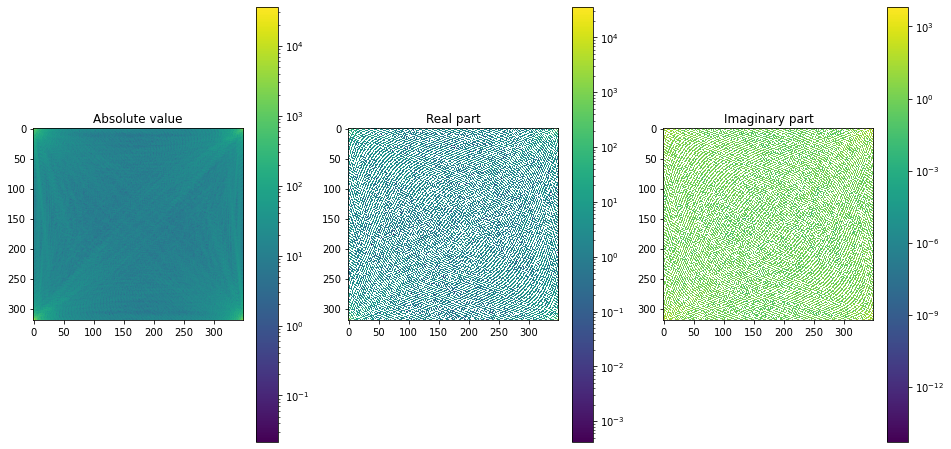

In [25]:
import numpy.fft as fft
ft_duck0 = fft.fft2(duck0)
print(duck0.shape, duck0.dtype, ft_duck0.shape, ft_duck0.dtype)

## now plot this stuff
figure(figsize=(16,8))
subplot(1,3,1)
title("Absolute value")
imshow(abs(ft_duck0), norm=matplotlib.colors.LogNorm())
colorbar()
subplot(1,3,2)
title("Real part")
imshow(ft_duck0.real, norm=matplotlib.colors.LogNorm())
colorbar()
subplot(1,3,3)
title("Imaginary part")
imshow(ft_duck0.imag, norm=matplotlib.colors.LogNorm())
_ = colorbar()

### Inverse FFT
Unsurprisingly, ``numpy.fft.ifft2`` performs the inverse operation, and gives us the duck back. Note that the result is formally a complex array, but since ``ft_duck0`` was the FT of a real image, its inverse also works out to be purely real (to within machine precision -- the tartan pattern in the imaginary plot is $\sim10^{-15}$, as you can see from the colourbar).

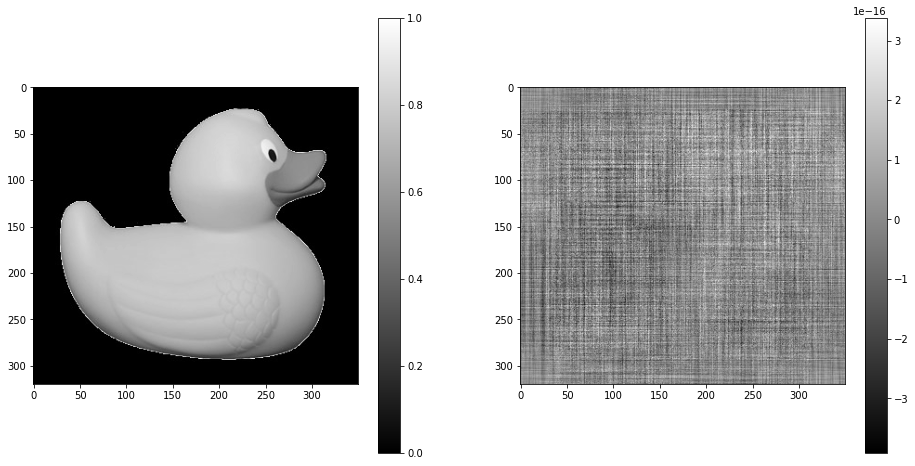

In [26]:
duck1 = fft.ifft2(ft_duck0)
figure(figsize=(16,8))
subplot(1,2,1)
imshow(duck1.real, cmap="gray")
_ = colorbar()
subplot(1,2,2)
imshow(duck1.imag, cmap="gray")
_ = colorbar()

## FFT frequencies & shifts
For definitions of what exactly the FFT functions compute, see https://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft. Note the following:

* For $n$ input points $\{ a_k \}_{k=0\ldots n-1}$ (in the 1D case), the Fourier transform gives us coefficients at $n$ output frequencies, numbered as $\{ A_k \}_{k=0\ldots n-1}$

* The frequencies from $n/2$ to $n-1$ are also called the *negative frequencies*. Negative frequency $-k$ is equivalent to $(n-k)$. (This actually makes sense of one scrutinizes the formula given at the link above, and imagines counting the input point backwards instead.)

* For a real-valued input signal, the FT is Hermitian, i.e. $A_{n-k} = A_k^*$. The 0-th frequency $A_0$ is purely real, and contains the total power in the input signal. (Thus, although the FT formally gives us $n$ complex numbers and therefore $2n$ real numbers, only $n$ of those numbers are unique -- no new information is invented!)

* For even $n$, the positive frequencies are $A_1$ to $A_{n/2-1}$, and the negative frequencies are $A_{n/2}$ to $A_{n-1}$ (thus there is one more negative frequency than positive). This is the convention adopted by numpy.fft, FFTW, MATLAB's FFT, etc.

* For odd $n$, there is an equal number of positive frequencies ($A_1$ to $A_{(n-1)/2}$) and negative frequencies ($A_{(n+1)/2}$ to $A_{n-1}$)

The ``fftfreq(n)`` function is a handy way to illustrate this. It returns the frequencies corresponding to an FT of $n$ points:

In [27]:
print(fft.fftfreq(4))
print(fft.fftfreq(5))

[ 0.    0.25 -0.5  -0.25]
[ 0.   0.2  0.4 -0.4 -0.2]


This ordering may seem a little backwards. In the lectures, we had the origin of the coordinate system, and thus the zero'th frequency, in the middle of the plane (a convention more palatable to humans, if not to computers!) The ``fftshift()`` family of functions rearranges arrays around to put the origin where we expect to find it:

[ 0.   0.2  0.4 -0.4 -0.2] [-0.4 -0.2  0.   0.2  0.4]


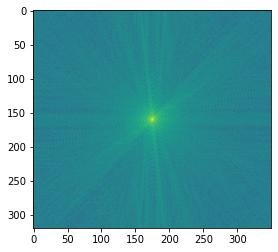

In [28]:
freqs = fft.fftfreq(5)
print(freqs, fft.fftshift(freqs))
## this also works on 2D images. Let's rearrange the duck-FT into a more familiar order...
# ...with low spatial frequencies in the middle
_ = imshow(fft.fftshift(abs(ft_duck0)), norm=matplotlib.colors.LogNorm())

The above is more recognizable -- the low spatial frequencies, corresponding to the large-scale features of the duck, have higher amplitudes -- and these are now clumped towards the centre of the Fourier plane.

Note that the same applies to the original image -- as far as the FFT functions are concerned, the (0,0) pixel of the image is at the upper left corner (i.e. the 0,0 array element). So if we think of the origin of our image as being at its center instead, we must do the inverse shift (``ifftshift()``) before we feed the image to the FFT. To avoid confusion, one must be careful to pick a coordinate convention and stick to it:

* origin at upper-left: no shifting

* origin at centre: inverse-shift images, shift FFTs

For the rest of this notebook, we'll use the origin-at-centre convention (because it makes certain visualizations easier). For convenience, let's define our own FFT and inverse FFT functions, to include the right shifts as appropriate:

In [29]:
def FFT(image):
    return fft.fftshift(fft.fft2(fft.ifftshift(image)))
def IFFT(ft):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ft)))

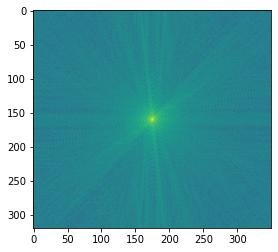

In [30]:
# here is the centre-origin FT of a duck
_ = imshow(abs(FFT(duck0)), norm=matplotlib.colors.LogNorm())

## A plotting function
Since we'll be doing a lot of plotting of images together with their Fourier transforms, let's write a convenience function for this. To avoid visual artefacts caused by machine precision (see the $10^{-15}$ tartan above), we'll include code to mask off very small values.

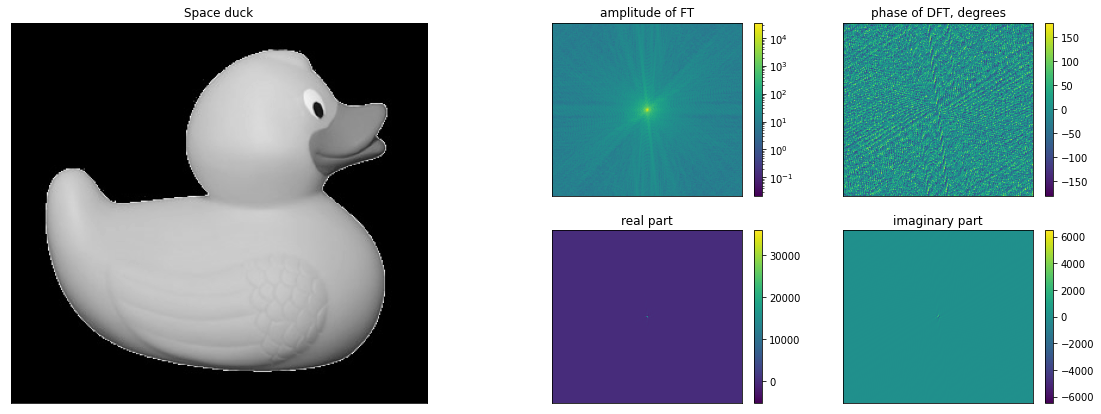

In [31]:
from numpy.ma import masked_array
def plotfft(x=None, fx=None, name="Space duck", amin=1e-3):
    """
    Plot original image 'x' and its FFT 'fx' (computing either automatically, if None is given)
    """
    if x is None:
        x = IFFT(fx).real
    else:
        fx = fx if fx is not None else FFT(x) 
    figure(figsize=(20,7))
    
    subplot(1,2,1)
    title(name)
    xim = x.copy()
    xim[x<1e-3] = 0
    imshow(xim, cmap="gray")
    xticks([]), yticks([])
    
    subplot(2,4,3)
    title("amplitude of FT")
    ampl = abs(fx)
    ampl[ampl<amin] = 0
    imshow(ampl, norm=matplotlib.colors.LogNorm())
    colorbar()
    xticks([]), yticks([])
    
    subplot(2,4,4)
    title("phase of DFT, degrees")
    # note that phase of very small numbers is poorly defined (due to machine precision etc.),
    # so we mask it off here
    phase = np.angle(fx)*180/math.pi
    phase[abs(phase)<amin] = 0
    phase = masked_array(phase, ampl<amin)
    imshow(phase)
    colorbar()
    xticks([]), yticks([])
    
    subplot(2,4,7)
    title("real part")
    fxr = fx.real.copy()
    fxr[abs(fxr)<amin] = 0
    imshow(fxr) #, vmin=-amax, vmax=amax)
    colorbar()
    xticks([]), yticks([])
    
    subplot(2,4,8)
    title("imaginary part")
    fxi = fx.imag.copy()
    fxi[abs(fxi)<amin] = 0
    imshow(fxi)#, vmin=-amax, vmax=amax)
    colorbar()
    xticks([]), yticks([])
    
    savefig(name.replace(" ","_")+".png",dpi=200)
    return x, fx

x, fx = plotfft(duck0)

## A space cigar
The duck contains many spatial frequencies, so it's FT is a bit difficult to interpret. Let us construct a space cigar instead. An Gaussian function of the form $\exp\{-\frac{x^2}{2\sigma_x^2} - \frac{x^2}{2\sigma_x^2}\}$ provides a handy approximation to a cigar:

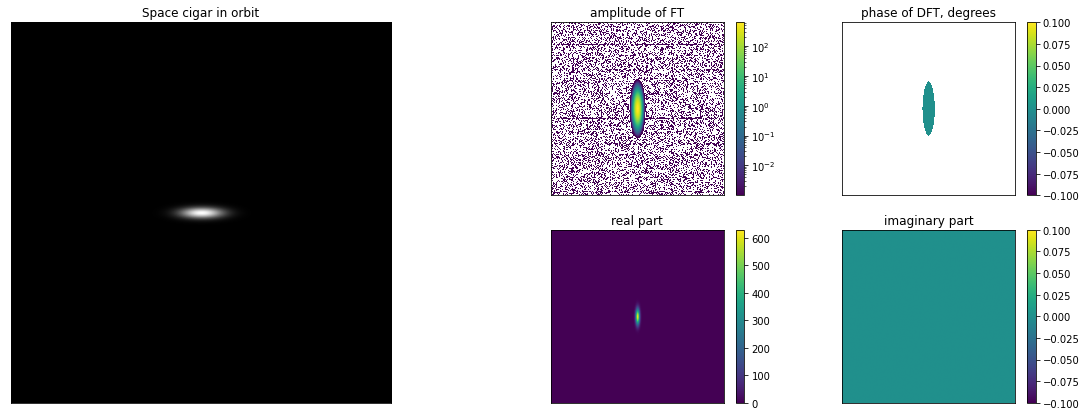

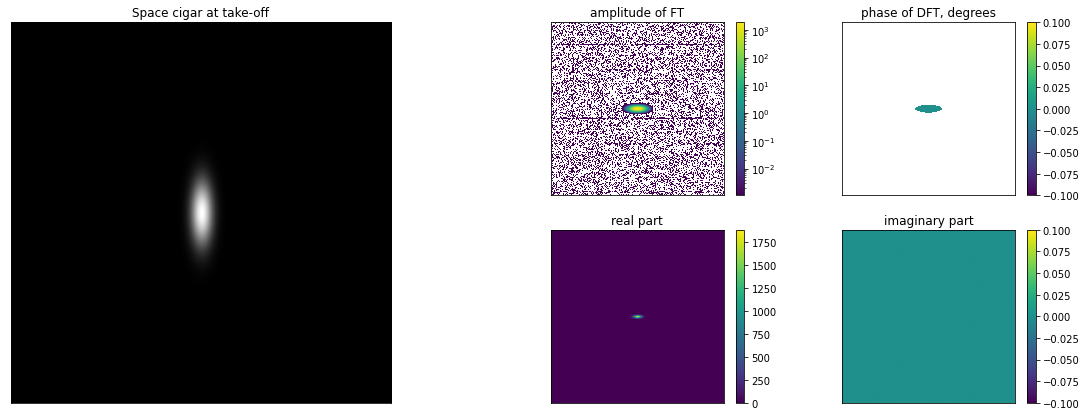

In [32]:
def space_cigar(xsize, ysize, xc=0, yc=0, shape=(512, 512)):
    """
    Generates 2D Gaussian image of the given shape, offset by xc,yc from centre.
    xsize and ysize give the respective widths of the Gaussian.
    """
    ny, nx = shape
    x0 = nx//2 + xc
    y0 = ny//2 + yc
    x = np.arange(0.,nx)[np.newaxis, :] - x0
    y = np.arange(0.,ny)[:, np.newaxis] - y0
    return np.exp(-(x/xsize)**2/2 - (y/ysize)**2/2)

_ = plotfft(space_cigar(20,5), name="Space cigar in orbit")
_ = plotfft(space_cigar(10,30), name="Space cigar at take-off")

The above plot already illustrates a few properties of FTs that we touched on during the lecture:

* The FT of a Gaussian is itself a Gaussian

* Fourier reciprocity: compare the cigar's dimensions to its footprint in the Fourier plane, and note how "large" things in the image translate into "small" things in the Fourier plane 

* Because the Gaussian is symmetric and centred on origin, there is zero Fourier phase (the FT is purely real). Remember, phase encodes position!

Let's play with this last property a little bit. First, let us make an offset cigar:

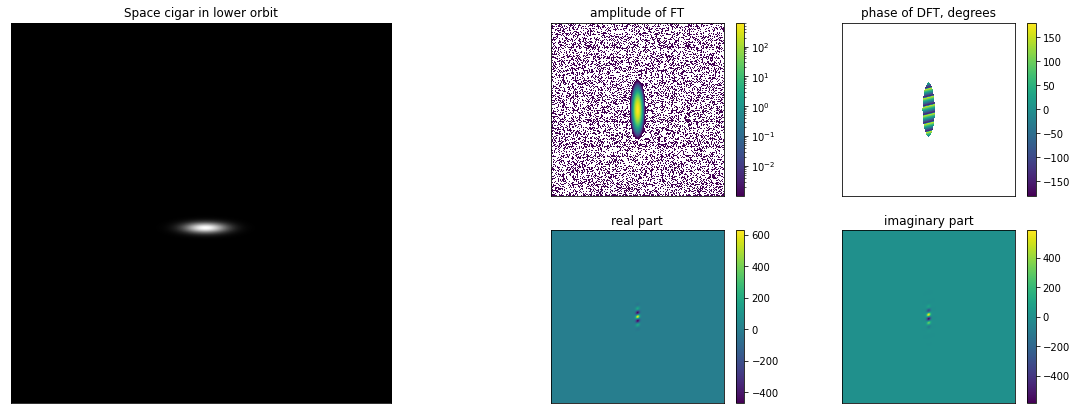

In [33]:
_ = plotfft(space_cigar(20,5, xc=5, yc=20), name="Space cigar in lower orbit")

The phase gradient is immediately apparent. This is the **Fourier Shift Theorem** coming through: an offset in image space is equivalent to a phase gradient in Fourier space. We can illustrate this even more starkly by collapsing our cigar into a single point:

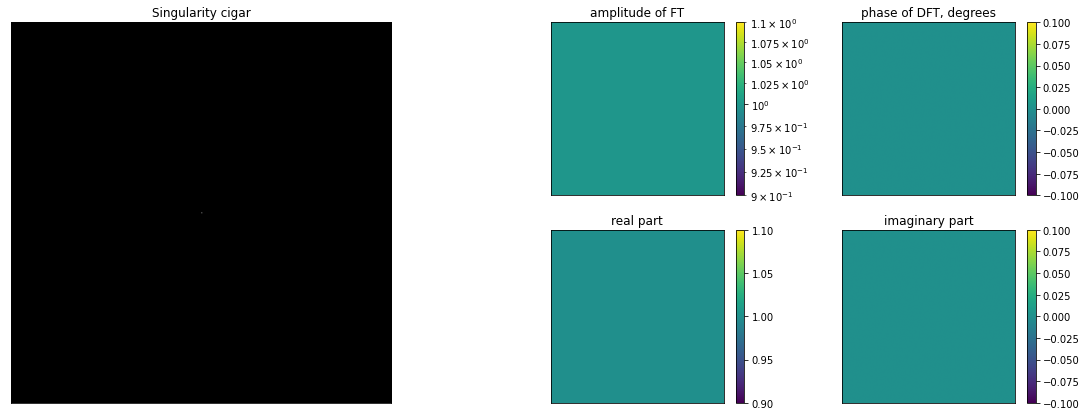

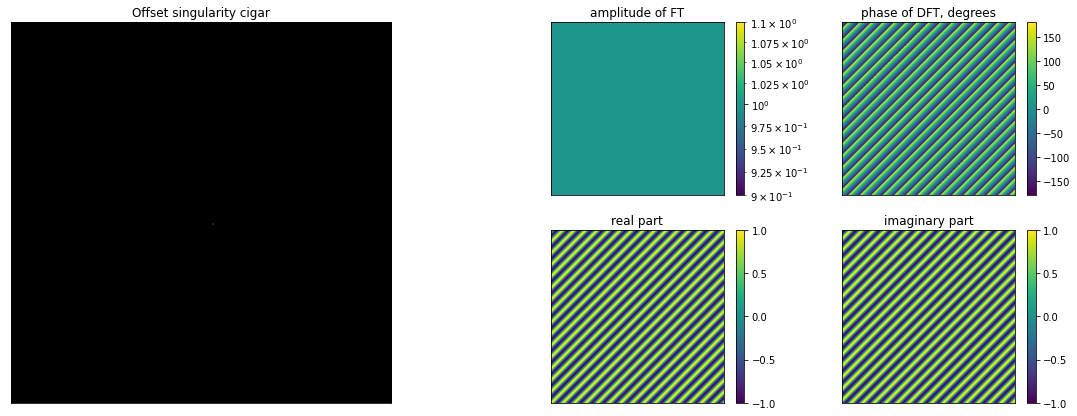

In [34]:
_ = plotfft(space_cigar(1e-99, 1e-99, xc=0, yc=0), name="Singularity cigar")
_ = plotfft(space_cigar(1e-99, 1e-99, xc=15, yc=15), name="Offset singularity cigar")

The above also illustrates another famour Fourier relationship: the FT of a delta function at origin (i.e. a single pixel, in case of a pixellated image) is just a constant.

## More fun with Fourier phases
To repeat the lecture question, does this work with the duck? Well of course it works with the duck! To illustrate this, a few more experiments.

First, let's take the FT of the duck, and apply the phase gradient above to it.

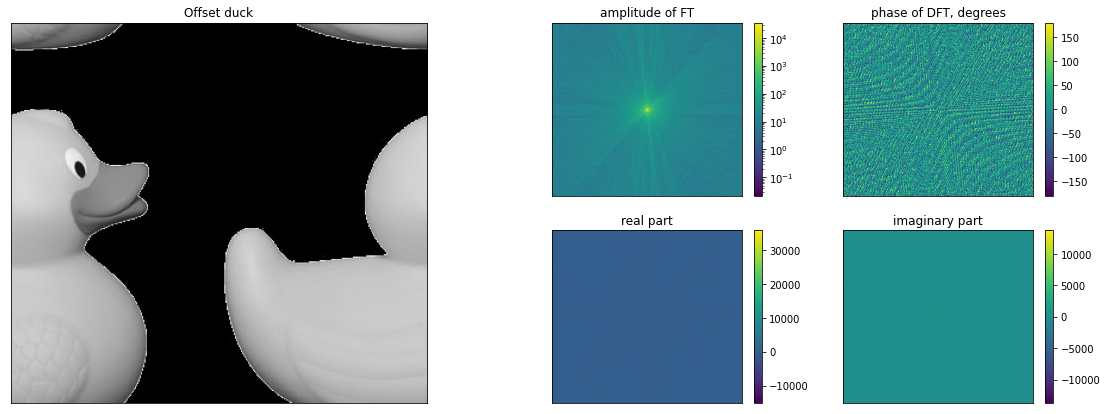

In [35]:
# take FT of an offset point (mind to make image same shape as the duck image)
ft_duck0 = FFT(duck0)
ft_offset_point = FFT(space_cigar(1e-99, 1e-99, xc=150, yc=50, shape=duck0.shape))
# make "new FT" by modifying the duck's FT's phase
ft_newduck = abs(ft_duck0) * np.exp(1j*(np.angle(ft_duck0)+np.angle(ft_offset_point)))
# note that plotfft() will do an inverse FFT of ft_newduck to make the new duck for us
_ = plotfft(fx=ft_newduck, name="Offset duck")

It is, indeed, a shifted duck! Now, what happens if we throw away the phases of the duck?

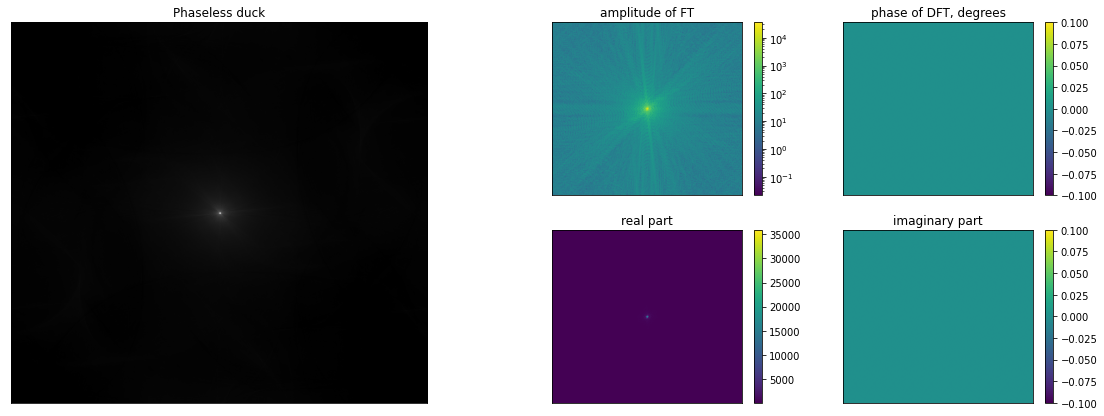

In [36]:
ft_newduck = abs(ft_duck0) + 0j
_ = plotfft(fx=ft_newduck, name="Phaseless duck")

And if we throw away the amplitudes of the duck (reset them all to 1)?

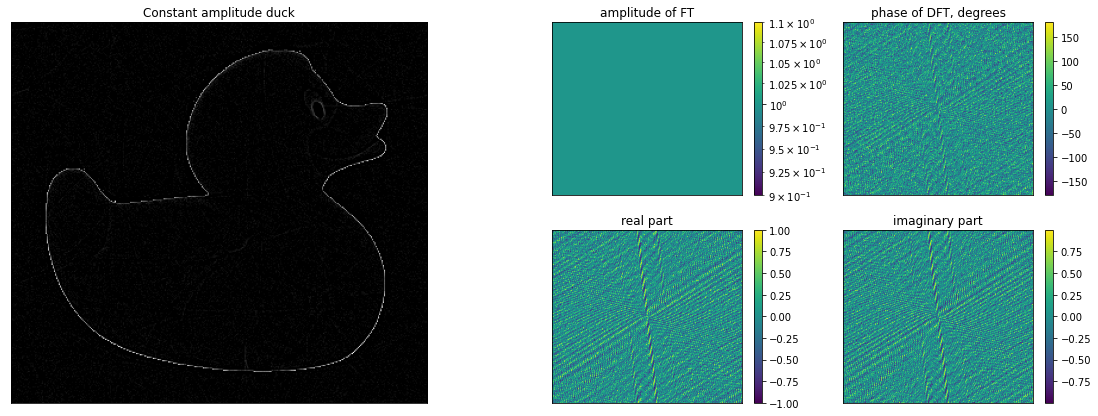

In [37]:
ft_newduck = np.exp(1j*np.angle(ft_duck0))
_ = plotfft(fx=ft_newduck, name="Constant amplitude duck")

Now, let's take that cigar again, and start playing with its amplitudes and phases:

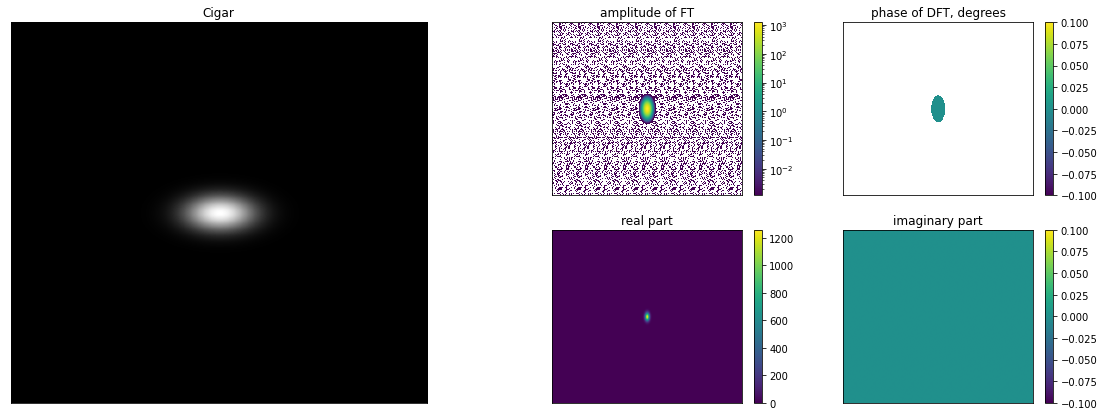

In [38]:
cigar, ft_cigar = plotfft(space_cigar(20, 10, shape=duck0.shape), name="Cigar")

For starters, let's take the Fourier amplitudes of the cigar, and the phases of the duck:

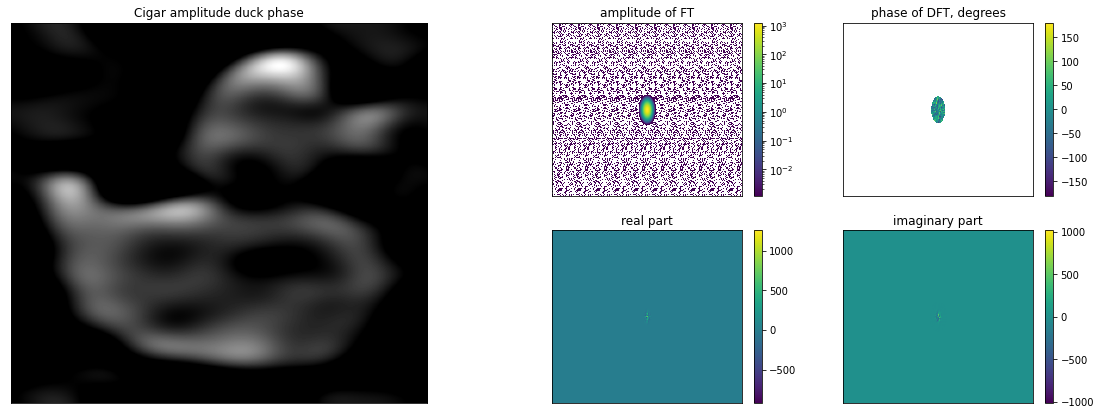

In [39]:
ft_newduck = abs(ft_cigar)*np.exp(1j*np.angle(ft_duck0))
_ = plotfft(fx=ft_newduck, name="Cigar amplitude duck phase")

And what about vice versa?

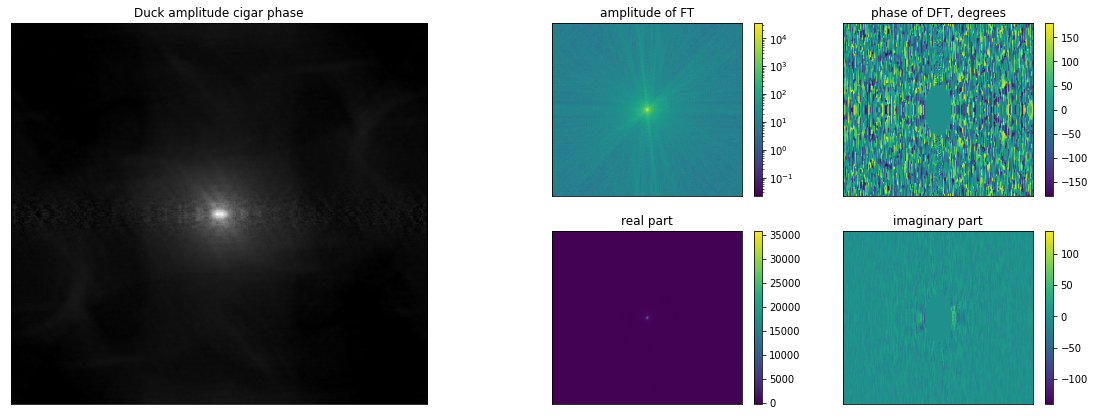

In [40]:
ft_newduck = abs(ft_duck0)*np.exp(1j*np.angle(ft_cigar))
_ = plotfft(fx=ft_newduck, name="Duck amplitude cigar phase")

What's going on with the phases in this last example? We shall leave this as an exercise to the reader...

## Sums, stretches, rotations

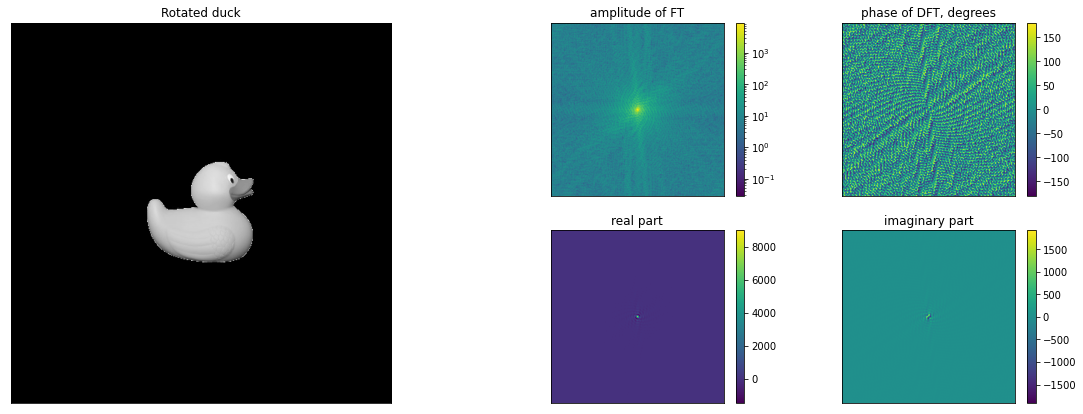

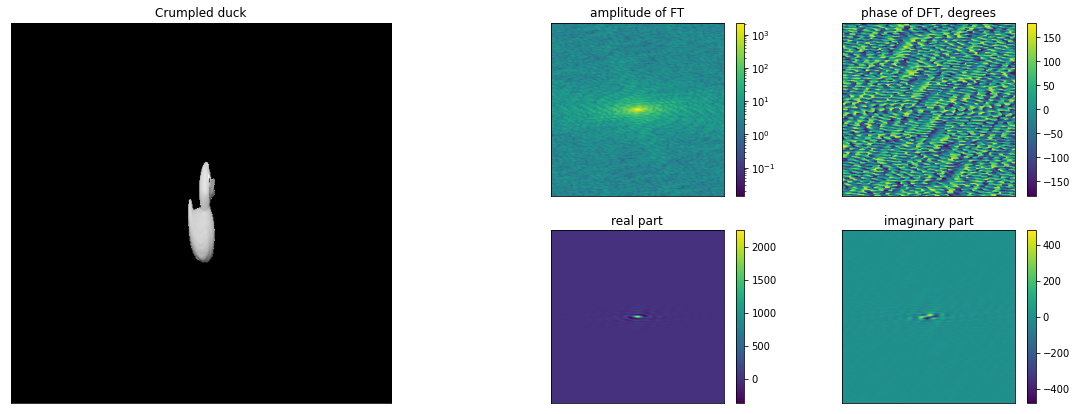

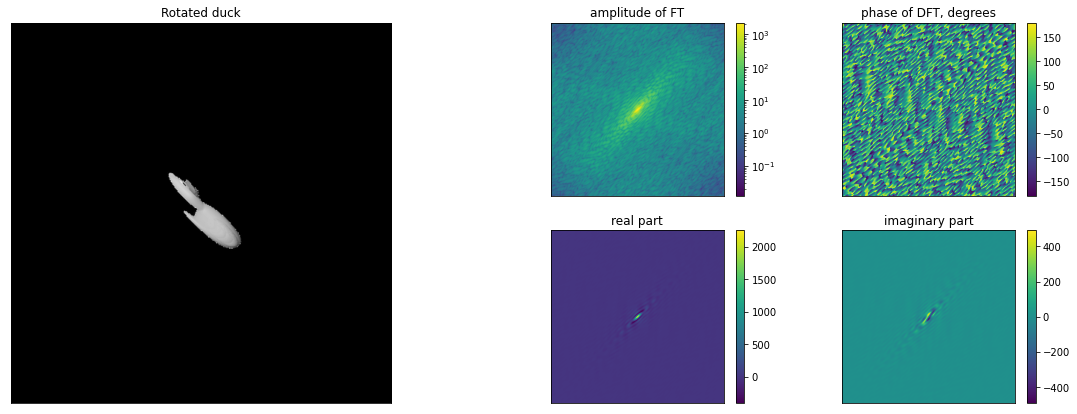

In [41]:
def zeropad(a, n=1024, x0=0, y0=0):
    """This function creates an empty array of size n x n, and pastes the image
    a into the middle of it (or at an offset of x0, y0 from centre)
    """
    nx, ny = a.shape
    pad_a = np.zeros((n, n), a.dtype)
    nx, ny = a.shape
    x0,y0 = (n - nx)//2+x0, (n - ny)//2+y0
    pad_a[x0:x0+nx,y0:y0+ny] = a
    return pad_a

# shrink the duck x2
shrunken_duck = zeropad(duck0[::2,::2], n=512)
_, shrunken_duck_ft = plotfft(shrunken_duck, name="Rotated duck")
# crumple the duck along the X axis
crumpled_duck = zeropad(duck0[::2,::8], n=512)
_, crumpled_duck_ft = plotfft(crumpled_duck, name="Crumpled duck")
# rotate the crumpled duck 45 degrees
rot_duck = scipy.ndimage.interpolation.rotate(crumpled_duck,45,reshape=False)
_, rot_duck_ft = plotfft(rot_duck, name="Rotated duck")

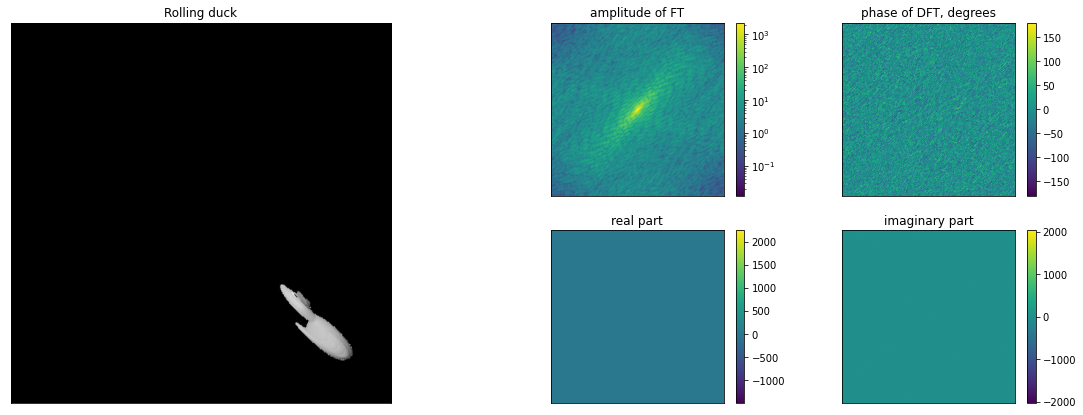

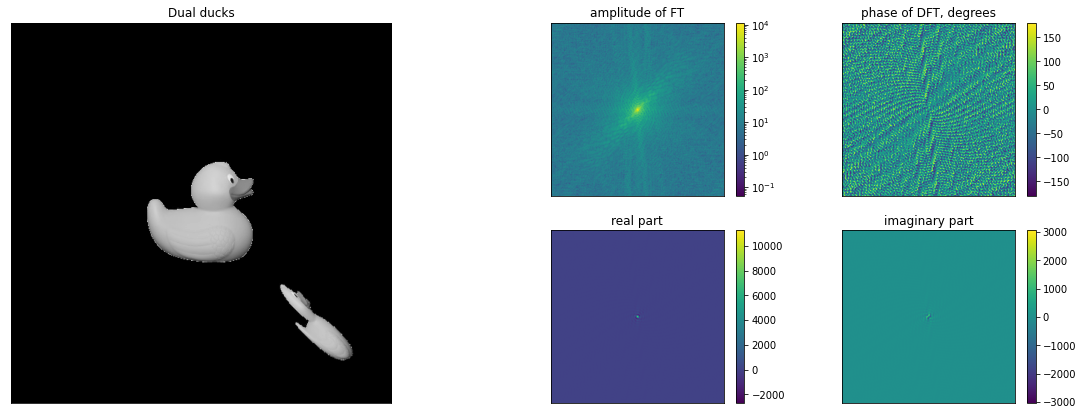

In [42]:
rolled_duck = np.roll(rot_duck, (150,150), axis=(0,1))
_, rolled_duck_ft = plotfft(rolled_duck, name="Rolling duck")
ft2 = shrunken_duck_ft + rolled_duck_ft 
_ = plotfft(fx=ft2, name="Dual ducks")

## Fourier interpolation
Here's a neat little trick which plays on the reciprocity between image space and Fourier space, if you think about it deeply enough... Let's start with a zoom into the duck's face:

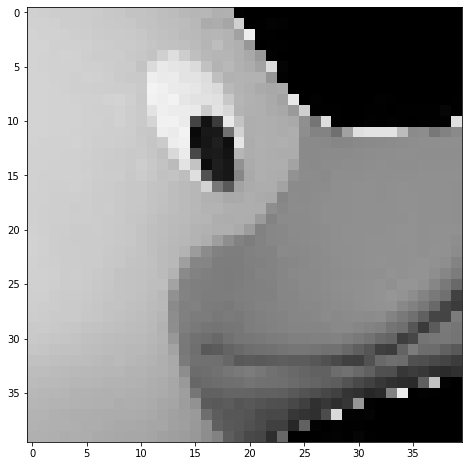

In [43]:
x0, y0, n = 200, 280, 40
figure(figsize=(8,8))
_ = imshow(shrunken_duck[x0:x0+n,y0:y0+n], cmap='gray', vmin=0, vmax=1)

At this resolution, it looks blocky, since we're beginning to see the individual pixels. Now, one way the **Fourier reciprocity** relationship manifests itself is that the *image pixel size* (i.e. the resolution, or the smallest element size, or the sampling rate of the image) is inversely proportional to the *overall Fourier size* (i.e. the highest available frequency) in Fourier space. So if we had access to *higher* frequencies in Fourier space, we could make an image with *smaller* pixels. Of course, without a higher-res image of the duck, we don't have that information, by definition. 

What we can do is to artificially construct a bigger Fourier space representation, by taking the FT of the duck, and padding it out with zeroes to represent the higher frequencies. The ``zeropad()`` function defined above will do exactly that. We then take an inverse FFT, and voila...

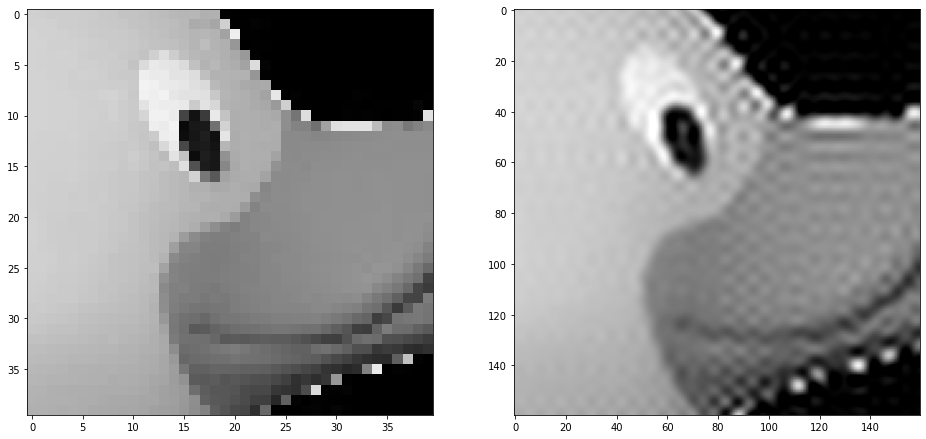

In [44]:
F = 4  # oversampling factor
figure(figsize=(16,8))
subplot(1,2,1)
# show zoom into duck's face
imshow(shrunken_duck[x0:x0+n,y0:y0+n], cmap='gray', vmin=0, vmax=1)
# zero-pad its FT
shrunken_duck_ft2 = zeropad(shrunken_duck_ft, n=shrunken_duck.shape[0]*F)
subplot(1,2,2)
# inverse the zero-padded FT
shrunken_duck2 = IFFT(shrunken_duck_ft2).real
# zoom into face -- note factor of F in coordinates, and F^2 in intensity
_ = imshow(shrunken_duck2[x0*F:(x0+n)*F,y0*F:(y0+n)*F]*F**2, cmap='gray', vmin=0, vmax=1)

The duck, interpolated to x4 higher resolution! Of course, all that's happening here is that, in effect, we're taking the sines and the cosines that make up the Fourier representation of the lower-resolution duck, and evaluating them on a higher-resolution grid. The FFT is simply a more efficient way to do this. This procedure (FT -- zero-pad -- IFT) is called *Fourier interpolation*.

Another way to put it is that *padding* in one space is *oversampling* in the other space.

NB: do also note the rescaling of the image intensity by a factor of $4^2$ that has to be done in the code above. This is to preserve the overall brightness level. The total intensity (sum of the pixel values) in the image is given by the zeroeth Fourier coefficient. Zero-padding the FT doesn't change this value -- and then the inverse FT (of the $\times 4^2$ bigger grid over $\times 4^2$ more pixels.

The plots below show what's going on, in a different way:

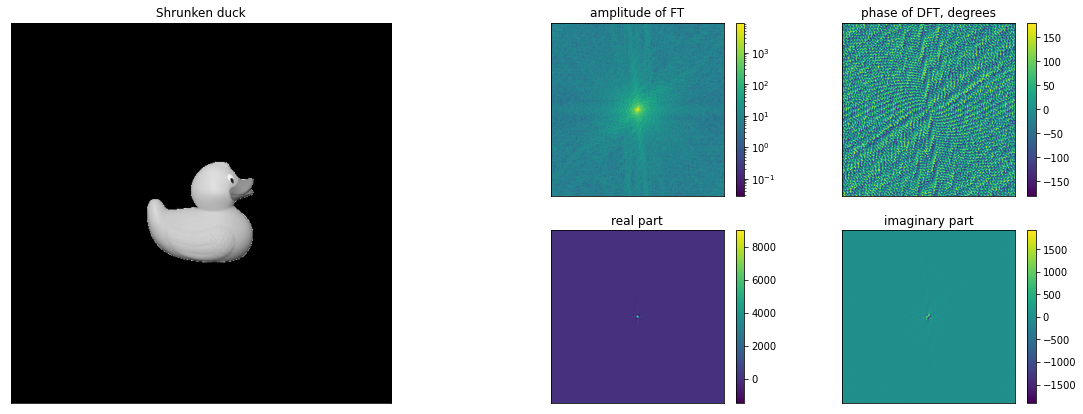

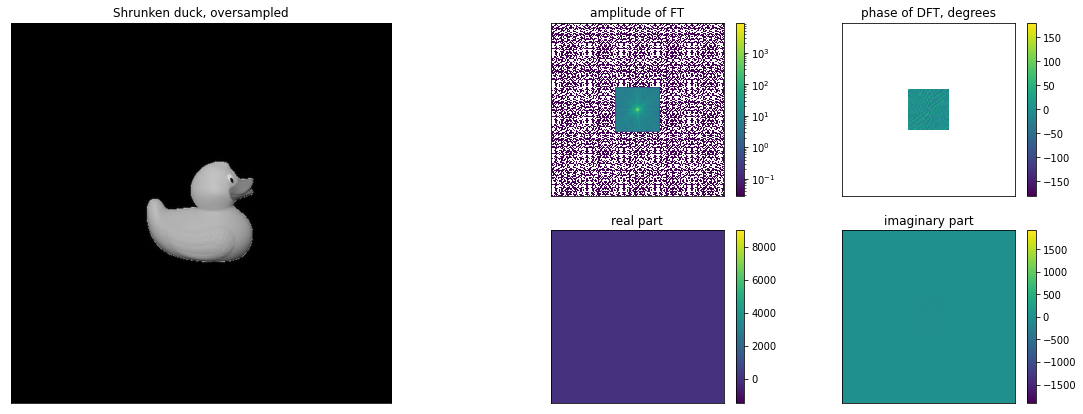

In [45]:
_ = plotfft(shrunken_duck, shrunken_duck_ft, name="Shrunken duck")
_ = plotfft(shrunken_duck2, shrunken_duck_ft2, name="Shrunken duck, oversampled")

## Periodicity
Another (reciprocally related, as you will see) fundamental point is that the FFT (or, more accurately, the DFT, where D stands for *discrete* -- the *fast* FT just being a fast way to compute a DFT) represents a **periodic signal**. This necessarily follows from its mathematical definition: a sum of $n$ sines and cosines *must* be periodic in image space. But our duck is not periodic, so what gives?

The answer, of course, is that the FT of the duck *actually* corresponds to an infinitely repeating duck. Like this:

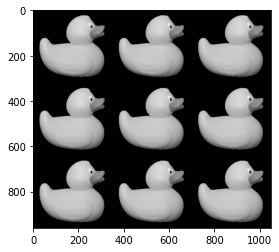

In [46]:
duck9 = np.block([[duck0,duck0,duck0],[duck0,duck0,duck0],[duck0,duck0,duck0]])
_ = imshow(duck9, cmap="gray")

Or even like this, ad infinitum...

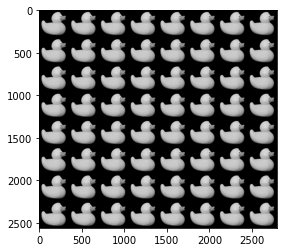

In [47]:
duck0x8 = np.block([[duck0]*8]*8)
_ = imshow(duck0x8, cmap="gray")

Now in if we take the FT of the "3x3 duck" above, we'll see a checkered pattern in the Fourier plane that may seem slightly odd at first:

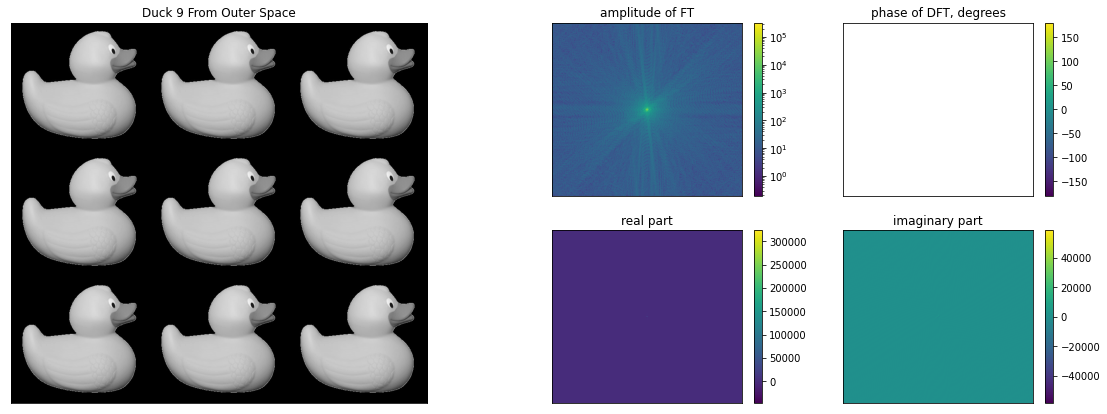

In [48]:
_, duck9_ft = plotfft(duck9, name="Duck 9 From Outer Space")

Until we look at the actual numbers in the FT, and notice that every two out of three rows and columns are zero, or virtually zero: 

In [49]:
print(duck9_ft)
print(duck9_ft[0,:10])

[[-1.21471765e+02+7.81597009e-14j  0.00000000e+00+0.00000000e+00j
  -1.87932821e-14-2.70331765e-14j ...  8.16522194e+01-2.38988364e+01j
  -1.21754758e-14-6.74181668e-15j  0.00000000e+00+0.00000000e+00j]
 [-1.31668281e-15+2.50025269e-17j  0.00000000e+00+0.00000000e+00j
  -5.59227923e-30-4.89025134e-30j ... -1.30919601e-15+4.59608647e-15j
   2.01150953e-30+5.46645153e-30j  0.00000000e+00+0.00000000e+00j]
 [-2.69068247e-15-9.28976420e-15j  0.00000000e+00+0.00000000e+00j
  -4.81879166e-30+4.72289997e-30j ...  4.96722959e-15+1.81424376e-14j
   2.96898337e-30-6.97985220e-31j  0.00000000e+00+0.00000000e+00j]
 ...
 [-3.29262476e+01-5.57485985e+01j  0.00000000e+00+0.00000000e+00j
  -1.69909311e-15+3.25050342e-14j ... -2.15331651e+01+5.15906910e+00j
  -2.65818126e-14+2.07717869e-14j  0.00000000e+00+0.00000000e+00j]
 [ 7.38616690e-15-7.54093841e-15j  0.00000000e+00+0.00000000e+00j
   1.64555414e-30+6.33062030e-30j ... -1.10394788e-14-5.11514225e-15j
  -5.54745501e-30-7.26896258e-31j  0.00000000e+

One way to look at it is as follows. The non-zero coefficients of the 3x3 duck FT are **precisely** the coefficients of the original (1x1 duck) FT. Now, as a mental experiment, consider Bob and Alice.

Let's say we Alice knows nothing about the sky. Bob gives Alice the FT coefficients (that he got from the 1x1 duck), and asks her what that tells her about the sky.

Given the sampling of the FT coefficients (i.e. the spacing between the frequencies), the biggest unique image that Alice can unambiguously reconstruct is a patch of sky only slightly larger than the original duck. After all, the sines and the cosines are periodic functions, so after a while the image is going to start repeating itself.

If Alice wanted to reconstruct a *bigger* image, she'd need to ask Bob to sample the "in between" frequencies, i.e. she'd ask for *finer* sampling in Fourier space (there's the reciprocity relationship again!) Without access to the "in between" frequencies, she can't know if the duck is alone in the sky, or is arranged in a 3x3 pattern of ducks, or whether it repeats infinitely -- all of those possible skies would give exactly the same set of original Fourier coefficients *at the original Fourier sampling*. If Alice was to do the simplest possible thing -- that is, assume a value of zero for the "in between" frequencies, and take the inverse Fourier transform -- she would end up with  an infinitely repeating duck.

Conversely, Alice could start with just the one duck, and ask the question, what would the in-between frequencies have to be if the duck was, in fact, alone and not periodic? Well, to answer that is as simple as zero-padding the duck and taking the Fourier transform:

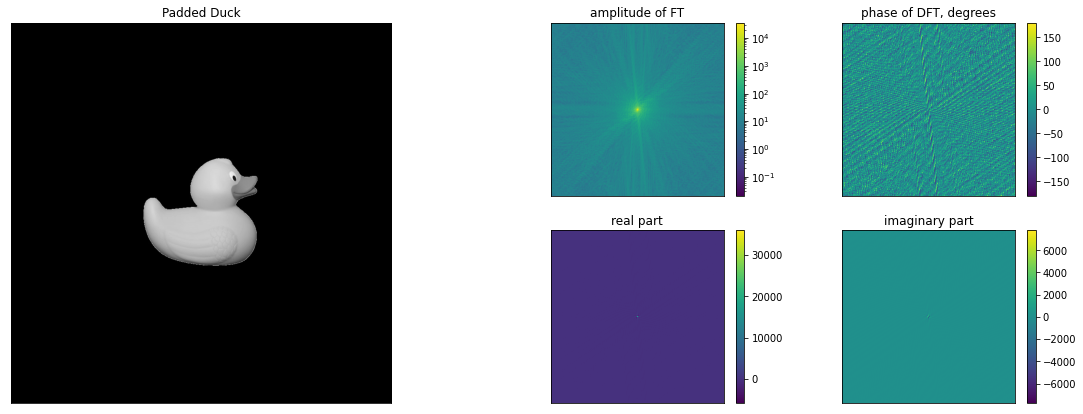

In [50]:
padded_duck = zeropad(duck0, n=duck0.shape[0]*3)
_ = plotfft(padded_duck, name="Padded Duck")

Voila, all the in-between frequencies are no longer zero. What's effectively happened is that *we have allowed the FFT to interpolate them, on the assumption that the duck is non-periodic and is, in fact, surrounded by empty sky*. Now, if you think about it, this is the exact equivalent of the Fourier interpolation we performed above, except now we're interpolating the Fourier components instead (by zero-padding in image space).

Further reading: this kind of interpolation hinges on sampling the original (known) Fourier coefficients on a uniform lower-resolution grid. In radio interferometric imaging, the Fourier coefficients are sampled on an irregular grid. The best way of interpolating these onto a uniform grid is an topic of research in itself, but is well outside the scope of this course. Look up *(convolutional) gridding* in radio astronomy, or *non-uniform FFTs*. 

## Fun with apertures
Now let's replicate the experiments we showed in the "van Cittert-Zernike Interlude" lectures. For starters, let's write some Python functions that make apertures, and apply them to the visibilities.

In [51]:
# given an array representing the FT (f0), takes the inverse FT to get an image, and plots that, along with the
# amplitude and phase of the FT
def plot_ifft(f0, name):
    x1 = np.fft.ifft2(np.fft.ifftshift(f0))
    x1 = np.fft.fftshift(x1)
    #x1 = numpy.fft.fftshift(x1)
    #x1 = numpy.fft.ifft2(f0)
    #x1 = numpy.fft.fftshift(x1)
    figure(figsize=(20,7), tight_layout=True)
    subplot(131)
    title(name)
    imshow(x1.real,cmap="gray")
    xticks([]), yticks([])
    subplot(132)
    title("amplitude of DFT")
    ampl = abs(f0)
    imshow(np.log10(ampl),vmin=0,vmax=6)
    xticks([]), yticks([])
    subplot(133)
    title("phase of DFT")
    phase = masked_array(np.angle(f0), ampl<1e-3)
    imshow(phase,vmin=-math.pi,vmax=math.pi)
    xticks([]), yticks([])
    savefig(name.replace(" ","_")+".png",dpi=200)
    return x1.real

# Given an image 'x' and a sampling function 'S', takes the FT of x, applies the sampling function to
# it, and then calls plot_ifft() to plot the resulting image
def apply_sampling(x, sampling, name):
    f0 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))
    f0[~sampling] = 0
    x1 = plot_ifft(f0, name)
    return f0,x1

# computes an aperture (sampling function) of a given radius (i.e. 1 within the radius, 0 outside)
def circular_aperture(R, nx=padded_duck.shape[0]):
    x0 = nx//2
    x2 = (np.arange(nx) - x0)**2
    r = x2[:, np.newaxis] + x2[np.newaxis, :] 
    return (r<R*R)

Now we can apply three different circular apertures to the duck, and see the result.

/tmp/ipykernel_4599/1562757927.py:17: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(ampl),vmin=0,vmax=6)


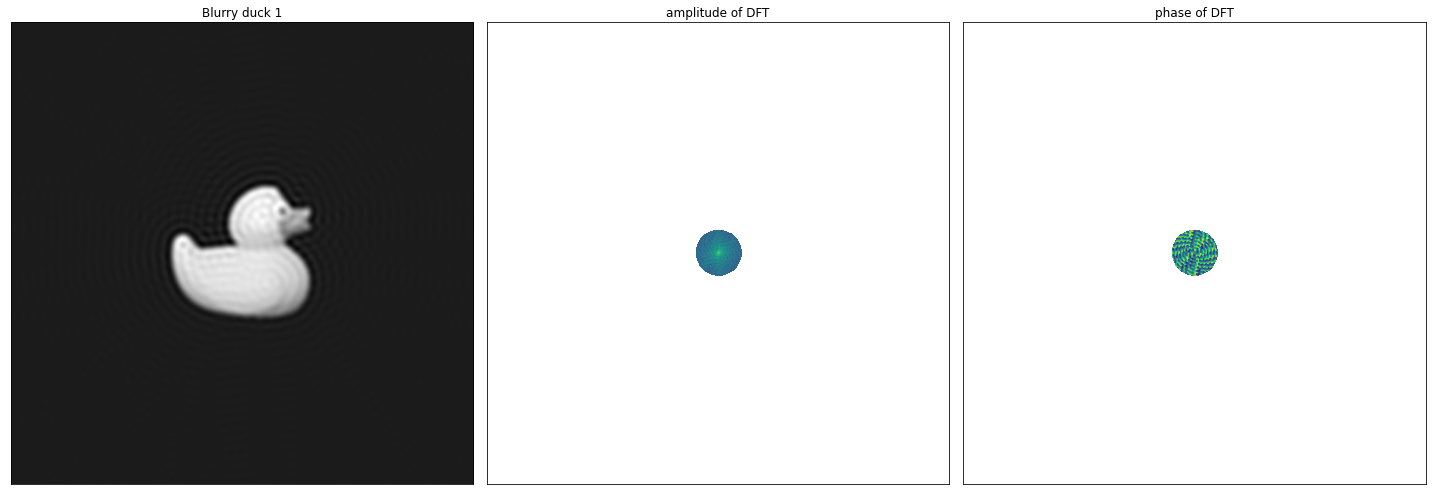

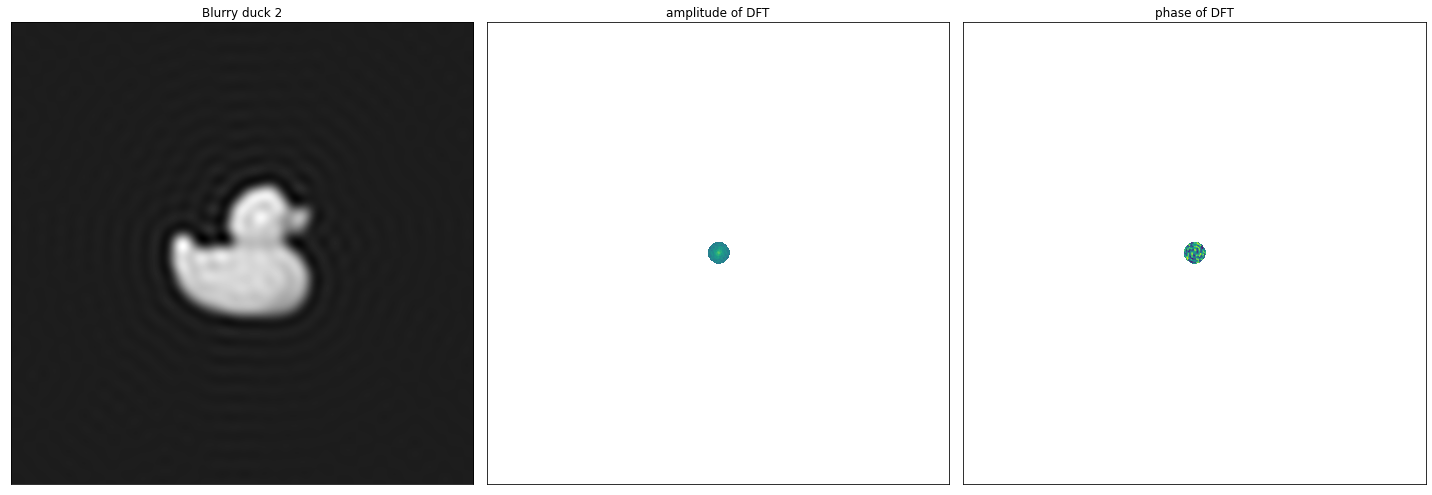

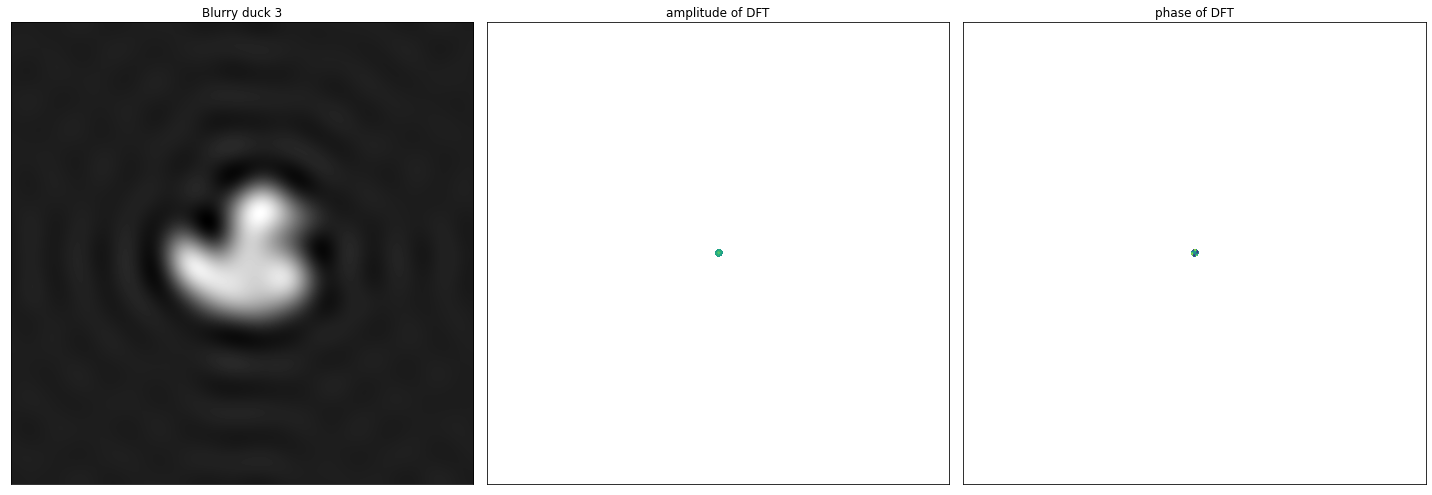

In [52]:
_ = apply_sampling(padded_duck, circular_aperture(50),"Blurry duck 1")
_ = apply_sampling(padded_duck, circular_aperture(25),"Blurry duck 2")
_ = apply_sampling(padded_duck, circular_aperture(10),"Blurry duck 3")


Now, instead of having a circular aperture at the centre, let's do something that is more akin to how a radio interferometer works -- let's sample the Fourier plane at randomly scattered points.

/tmp/ipykernel_4599/1562757927.py:17: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(ampl),vmin=0,vmax=6)


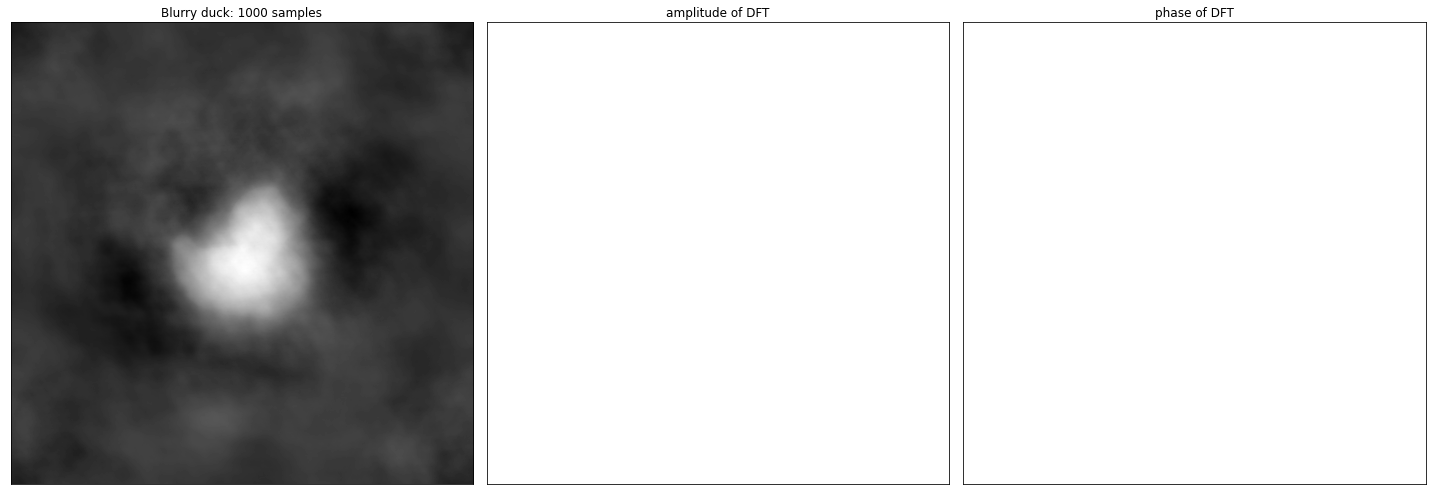

In [53]:
import numpy.random
import math
import scipy.ndimage
from scipy.ndimage.morphology import binary_dilation

# This makes a "random" UV-sampling function, by picking N random points in the plane
# Note that amplitude and phase are chosen randomly, which results in a concentration of points 
# towards the centre of the uv-plane (similarly to what happens in a radio interferometer, where
# we usually have more short spacings than long ones)
def random_uv(N, r=2, nx=padded_duck.shape[0]):
    mask = numpy.zeros((nx,nx), bool)
    r = numpy.random.random(N)*nx/2
    ang = numpy.random.random(N)*2*math.pi
    x = nx/2 + r*np.cos(ang)
    y = nx/2 + r*np.sin(ang)
    mask[x.astype(int),y.astype(int)] = True
    mask = binary_dilation(mask)
#    mask = binary_dilation(mask, scipy.ndimage.generate_binary_structure(2, 2))
    return mask

_ = apply_sampling(padded_duck, random_uv(1000), "Blurry duck: 1000 samples")

And *that* is how a space duck would look like to an interferometer with 1000 baselines (note that we're not doing any Earth rotation here.) If we want better image quality, we have to up the baseline numbers:

/tmp/ipykernel_4599/1562757927.py:17: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(ampl),vmin=0,vmax=6)


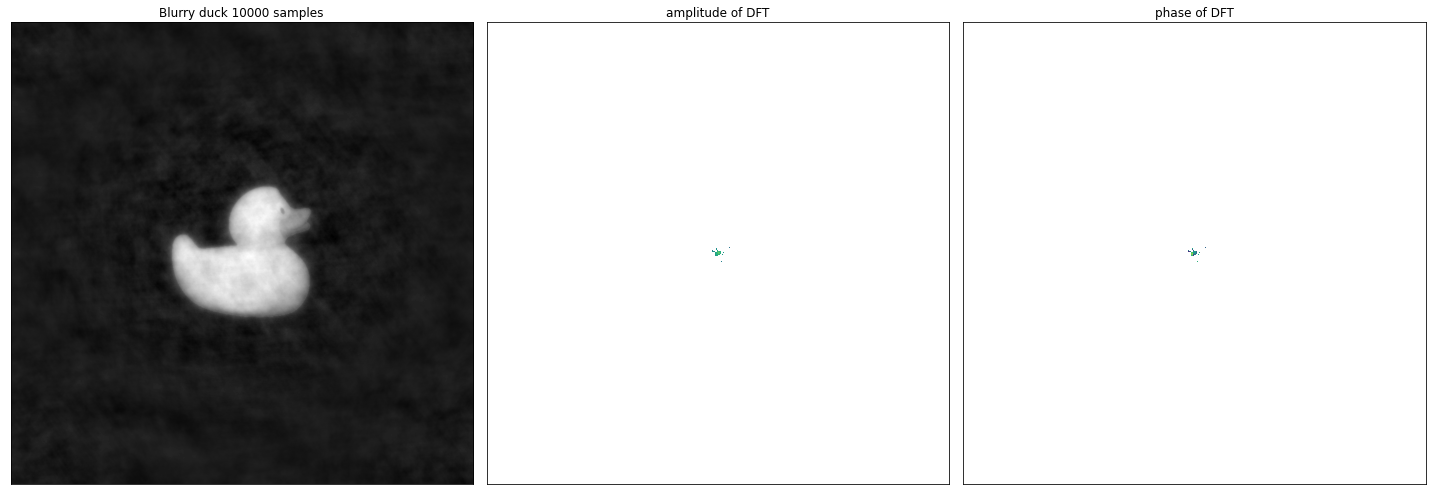

In [54]:
_ = apply_sampling(padded_duck, random_uv(10000), "Blurry duck 10000 samples")


## And that's all, folks!
This concludes our Fourier exercises. Using this notebook, you should have been able to replicate all of the examples given in the lectures. Please feel free to play with the code further, to see what more can be done with space ducks, cigars, and Fourier transforms.